# Analisi Volume di Traffico della Metro

### Progetto di Programmazione di Applicazioni Data Intensive

*2019/2020*

Realizzato da: **Marco Drudi**

*0000838384*

**marco.drudi5@studio.unibo.it**

## Descrizione del Problema
* Cerchiamo di predirre il volume di traffico di una linea della metro in vari momenti di diverse giornate avendo a disposizione diverse informazioni metereologiche e della giornata.
* Ipotiziamo di disporre già di un dataset contenente le informazioni e i volumi del traffico.
* Studiamo i dati a nostra disposizione per fare previsioni.

## Librerie Utilizzate

* Numpy: utilizzata per la creazione e la manipolazione di strutture matematiche (arrat n-dimensionali, ...)
* pandas: per il caricamento e la gestione ottimale di dati in formato tabulare.
* matplotlib: necessaria per la creazione di grafici.
* sklearn: indispensabile per il processo di Regressione.

Utilizzo gli alias convenzionali e abilito l'uso di grafici in-line.

In [330]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn
import datetime

%matplotlib inline

## Caricamento dei dati
Carichiamo ora il dataset con le recensioni, punteggi e prezzi dei vini ottenuto da [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz).

Il dataset è stato ricavato analizzando il volume di traffico dell'Interstate 94 in direzione ovest per la stazione MN DoT ATR 301, all'incirca a metà strada tra Minneapolis e St Paul. Sono incluse informazioni metereologiche e festività perchè di impatto sul volume dei dati.
### Significato delle colonne
Le feature presenti nel Dataset sono: 

- `holiday`: indica se presente una festività nazionale
- `temp`: temperatura media in kelvin
- `rain_1h`: quantità in mm di pioggia verificatasi in quell'ora
- `snow_1h`: quantità in mm di neve verificatasi nell'ora
- `clouds_all`: percentuale di nuvolosità
- `weather_main`: breve descrizione testuale del tempo corrente
- `weather_description`: descrizione più lunga del tempo corrente
- `date_time`: data e ora dei dati raccolti nell'ora CST locale


La variabile che tenteremo di predirre è:
- `traffic_volume`: volume di traffico del I-94 ATR 301 che è stato registrato in direzione ovest

In [331]:
import os.path
file = "Metro_Interstate_Traffic_Volume.csv";
if not os.path.exists(file):
    print("Missing dataset, retrieve it from:");
    print("https://archive.ics.uci.edu/ml/machine-learning-databases/00492/");

In [332]:
parse_date = ["date_time"]
metro = pd.read_csv(file, parse_dates=parse_date, nrows=2000)

### Obbiettivo
L'obbiettivo è quello di stimare il volume di traffico della metro.

Osserviamo alcune informazioni sul dataset:

In [333]:
metro.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 9 entries, holiday to traffic_volume
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 468.3 KB


In [334]:
metro.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description           date_time  traffic_volume  
0    scattered clouds 2012-10-02 09:00:00            5545  
1       broken clouds 2012-10-02 10:00:00            4516  
2     overcast clouds 2012-10-02 11:00:00            4767  
3     overcast clouds 2012-10-02 12:00:00            5026  
4       broken clouds 2012-10-02 13:00:00            4918

In [335]:
metro['holiday'].value_counts()

None                1997
Thanksgiving Day       1
Veterans Day           1
Columbus Day           1
Name: holiday, dtype: int64

In [336]:
metro['weather_main'].value_counts()

Clouds          971
Clear           319
Mist            283
Rain            117
Snow            116
Drizzle          76
Haze             60
Fog              45
Thunderstorm     13
Name: weather_main, dtype: int64

In [337]:
metro['weather_description'].value_counts()

overcast clouds                     438
sky is clear                        319
mist                                283
broken clouds                       239
few clouds                          151
scattered clouds                    143
heavy snow                           97
light rain                           87
haze                                 60
light intensity drizzle              52
fog                                  45
moderate rain                        25
drizzle                              23
snow                                 19
proximity thunderstorm                7
heavy intensity rain                  4
thunderstorm with light rain          3
thunderstorm with heavy rain          2
proximity thunderstorm with rain      1
heavy intensity drizzle               1
proximity shower rain                 1
Name: weather_description, dtype: int64

Osseriviamo che delle 9 features **3** sono categoriche (`holiday`, `weather_main`, `weather_description`).

Si sceglie quindi di caricarle in memoria come considerato nella precedente affermazione.

In [338]:
categories = ['holiday', 'weather_main', 'weather_description']
metro = pd.read_csv(file, parse_dates=parse_date, dtype={x:"category" for x in categories}, nrows=2000)

In [339]:
metro.info(verbose=False, memory_usage="deep")
metro.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 9 entries, holiday to traffic_volume
dtypes: category(3), datetime64[ns](1), float64(3), int64(2)
memory usage: 103.1 KB


holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description           date_time  traffic_volume  
0    scattered clouds 2012-10-02 09:00:00            5545  
1       broken clouds 2012-10-02 10:00:00            4516  
2     overcast clouds 2012-10-02 11:00:00            4767  
3     overcast clouds 2012-10-02 12:00:00            5026  
4       broken clouds 2012-10-02 13:00:00            4918

Vediamo come lo spazio in memoria sia diminuito.

Tutte le features sono ritenute *rilevanti*, in caso contrario avrei potuto rimuovere quelle inutili.

## Analisi generale dei dati
Visualizziamo alcune statistiche per prendere coscienza dei dati che dovremo analizzare e delle caratteristiche del dominio applicativo.

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [340]:
for x in ['holiday', 'weather_main', 'weather_description']:
    print(x+":  \t"+ str(metro[x].nunique()));

holiday:  	4
weather_main:  	9
weather_description:  	21


Il dataframe contiene quindi **12** possibili festività, **11** possibili situazioni metereologiche e **38** possibilii descrizioni metereologiche

In [341]:
for x in ['holiday', 'weather_main', 'weather_description']:
    print(x+": " + str(metro[x].cat.categories))

holiday: Index(['Columbus Day', 'None', 'Thanksgiving Day', 'Veterans Day'], dtype='object')
weather_main: Index(['Clear', 'Clouds', 'Drizzle', 'Fog', 'Haze', 'Mist', 'Rain', 'Snow',
       'Thunderstorm'],
      dtype='object')
weather_description: Index(['broken clouds', 'drizzle', 'few clouds', 'fog', 'haze',
       'heavy intensity drizzle', 'heavy intensity rain', 'heavy snow',
       'light intensity drizzle', 'light rain', 'mist', 'moderate rain',
       'overcast clouds', 'proximity shower rain', 'proximity thunderstorm',
       'proximity thunderstorm with rain', 'scattered clouds', 'sky is clear',
       'snow', 'thunderstorm with heavy rain', 'thunderstorm with light rain'],
      dtype='object')


Le festività sono: `Christmas Day`, `Columbus Day`, `Independence Day`, `Labor Day`,
       `Martin Luther King Jr Day`, `Memorial Day`, `New Years Day`, `None`,
       `State Fair`, `Thanksgiving Day`, `Veterans Day`,
       `Washingtons Birthday`.
       
Le possibili situazioni metereologiche sono: `Clear`, `Clouds`, `Drizzle`, `Fog`, `Haze`, `Mist`, `Rain`, `Smoke`,
       `Snow`, `Squall`, `Thunderstorm`.

Concentriamoci ora sulle diverse distribuzioni delle festività.

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


None                1997
Veterans Day           1
Thanksgiving Day       1
Columbus Day           1
Name: holiday, dtype: int64

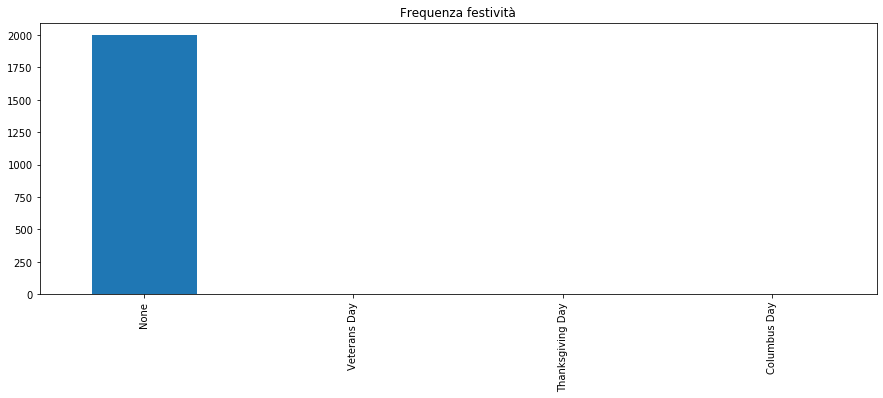

In [342]:
metro['holiday'].value_counts().plot.bar(figsize=(15, 5));
plt.axes().set_title('Frequenza festività');
metro['holiday'].value_counts()

Come possiamo vedere la maggior parte dei momenti analizzati erano in giornate in cui non era presente nessuna festività nazionale.

Concentriamoci ora sulla distribuzione delle situazioni metereologiche.

In [343]:
metro['weather_main'].value_counts().plot.bar(figsize=(15, 5));
plt.axes().set_title('Situazioni metereologiche');

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Concentriamoci ora sulla distribuzione delle descrizioni metereologiche.

In [344]:
metro['weather_description'].value_counts().plot.bar(figsize=(15, 5));
plt.axes().set_title('Descrizioni metereologiche');

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Osserviamo ora qualche statistica sulla temperatura.

In [345]:
metro['temp'].describe()

count    2000.000000
mean      277.313895
std         6.865219
min       255.940000
25%       272.520000
50%       277.625000
75%       281.995000
max       298.170000
Name: temp, dtype: float64

Osserviamo ora qualche statistica sul volume dei dati.

In [346]:
metro['traffic_volume'].describe()

count    2000.00000
mean     3309.94600
std      2034.69904
min       216.00000
25%      1217.00000
50%      3477.00000
75%      5115.75000
max      7189.00000
Name: traffic_volume, dtype: float64

### Correlazioni tra Features
I grafici a dispersione che andremo a mostrare evidenzieranno eventuali correlazioni tra features.

Osserviamo la distribuzione del volume di traffico in base alle festività nazionali.

None                1997
Veterans Day           1
Thanksgiving Day       1
Columbus Day           1
Name: holiday, dtype: int64


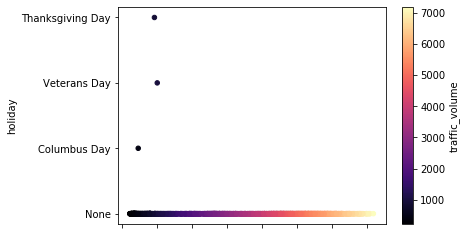

In [347]:
metro.plot.scatter('traffic_volume', 'holiday', c='traffic_volume', colormap="magma");
print(metro['holiday'].value_counts())

Come possiamo vedere nei giorni di festività nazionale il volume di traffico è minore della media.

In [348]:
metro['rain_1h'] = metro['rain_1h'].drop(metro['rain_1h'].idxmax())

Osserviamo la distribuzione del volume di traffico in base ai mm di pioggia caduta.

0.0    1999
Name: rain_1h, dtype: int64


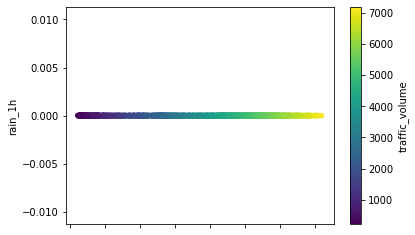

In [349]:
metro.plot.scatter('traffic_volume', 'rain_1h', c='traffic_volume', colormap="viridis");
print(metro['rain_1h'].value_counts())

Osserviamo la distribuzione del volume di traffico in base ai mm di neve caduta.

0.0    2000
Name: snow_1h, dtype: int64


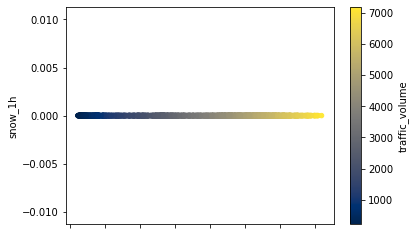

In [350]:
metro.plot.scatter('traffic_volume', 'snow_1h', c='traffic_volume', colormap="cividis");
print(metro['snow_1h'].value_counts())

Osserviamo la distribuzione del volume di traffico in base alla descrizione della situazione metereologica.

overcast clouds                     438
sky is clear                        319
mist                                283
broken clouds                       239
few clouds                          151
scattered clouds                    143
heavy snow                           97
light rain                           87
haze                                 60
light intensity drizzle              52
fog                                  45
moderate rain                        25
drizzle                              23
snow                                 19
proximity thunderstorm                7
heavy intensity rain                  4
thunderstorm with light rain          3
thunderstorm with heavy rain          2
proximity thunderstorm with rain      1
heavy intensity drizzle               1
proximity shower rain                 1
Name: weather_description, dtype: int64


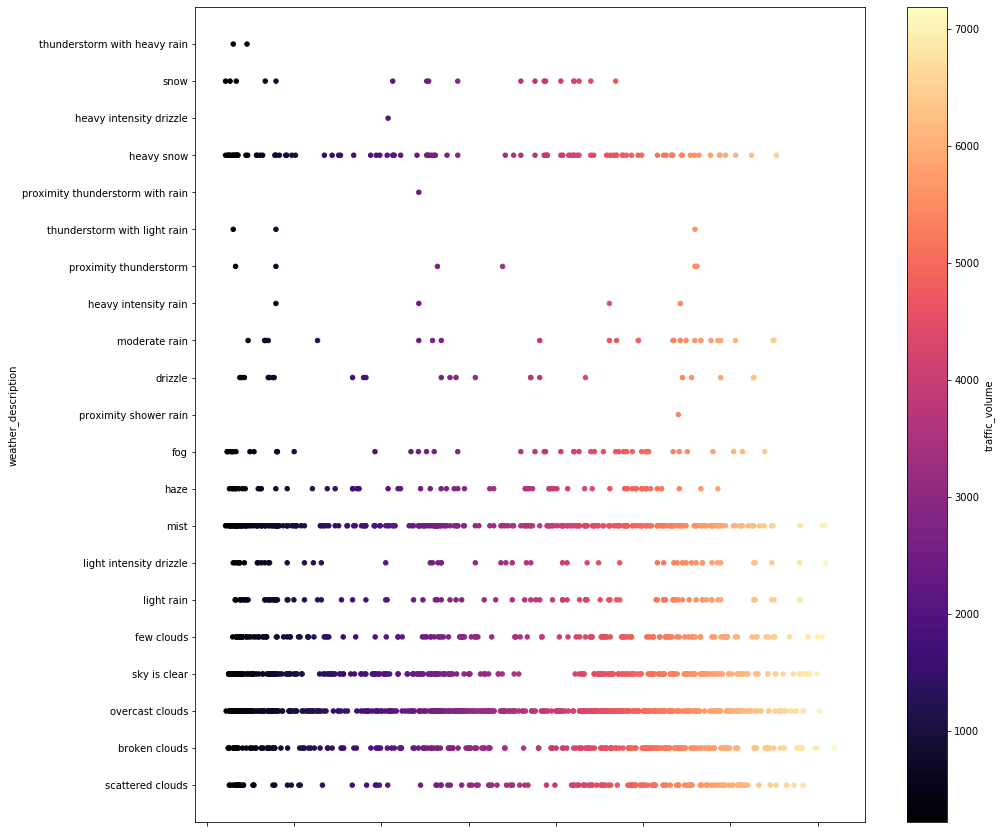

In [351]:
metro.plot.scatter('traffic_volume', 'weather_description', c='traffic_volume', colormap="magma", figsize=(15, 15));
print(metro['weather_description'].value_counts())

## Preparazione dei dati

Prepariamo ora i dati caricati ad essere elaborati dal modello, selezioniamo le feature che possono essere più interessanti e gestiamo i valori nulli.

Vediamo ora quanti valori nulli abbiamo nel dataframe per le varie colonne.

In [352]:
metro.shape[0]-metro.count()

holiday                0
temp                   0
rain_1h                1
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

Notiamo la presenza di tre valori nulli nella colonna `rain_1h`.

Dal momento che il valore non è deducibile da altri parametri ed essendo presenti solo tre valori nulli su un numero elevato di osservazioni decidiamo di eliminare le tre righe con valori nulli.

In [353]:
metro.dropna(subset=['rain_1h'], inplace=True)

Selezione delle feature rilevanti ed eliminazione delle ridondanze.

In [354]:
for x in metro:
    print(x+": " + str(metro[x].nunique()))

holiday: 4
temp: 1178
rain_1h: 1
snow_1h: 1
clouds_all: 32
weather_main: 9
weather_description: 21
date_time: 1692
traffic_volume: 1440


Decido inizialmente di usare tutte le variabili a disposizione.

### Conversione dei Dati

In [355]:
metro.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   
5    None  291.72      0.0      0.0           1        Clear   

  weather_description           date_time  traffic_volume  
1       broken clouds 2012-10-02 10:00:00            4516  
2     overcast clouds 2012-10-02 11:00:00            4767  
3     overcast clouds 2012-10-02 12:00:00            5026  
4       broken clouds 2012-10-02 13:00:00            4918  
5        sky is clear 2012-10-02 14:00:00            5181

La feture `date_time` che rappresenta la data e l'ora della rilevazione è più utile se scomposta in due feature `date` e `time`.

In [356]:
metro['date'] = [d.date() for d in metro['date_time']]
metro['time'] = [d.time() for d in metro['date_time']]
metro = metro.drop(columns="date_time")

In [357]:
columnsTitles = ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'
                , 'date', 'time', 'traffic_volume']
metro = metro.reindex(columns=columnsTitles)

Il tipo di dato della feature `time` viene convertita in un numero intero.

In [358]:
metro['time'] = [d.hour for d in metro['time']]

8     95
9     93
4     91
6     88
10    87
15    86
3     86
5     84
11    84
14    84
16    83
12    83
13    82
17    82
1     82
7     82
18    81
2     80
0     80
20    80
19    79
23    79
21    76
22    72
Name: time, dtype: int64


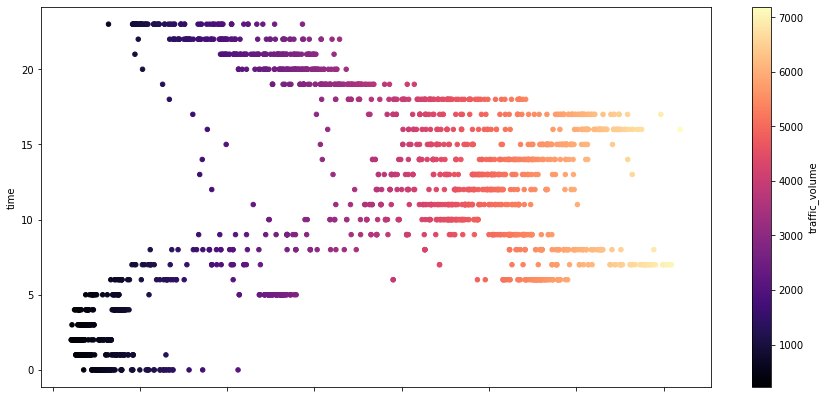

In [359]:
metro.plot.scatter('traffic_volume', 'time', c='traffic_volume', colormap="magma", figsize=(15, 7));
print(metro['time'].value_counts())

Notiamo che a seconda dell'orario il volume di traffico varia, quindi è presente una correlazione tra i due dati.

Decidiamo di eliminare l'attributo `date` in quanto non utile per la previsione del volume del traffico.

In [360]:
metro = metro.drop(columns='date')

Converto i dati testuali in numerici.

In [361]:
metrocpy = metro.copy(deep=True)

In [362]:
metro['holiday'] = metro['holiday'].str.replace(" ", "")
metro['weather_description'] = metro['weather_description'].str.replace(" ", "")

In [363]:
metro['holiday'] = metro['holiday'].map(dict(LaborDay=2, ChristmasDay=3, NewYearsDay=4, ThanksgivingDay=5, MartinLutherKingJrDay=6, VeteransDay=7, MemorialDay=8, StateFair=9, WashingtonsBirthday=10, IndependenceDay=11, ColumbusDay=12))
metro['holiday'] = metro['holiday'].fillna(value=1)
metro['weather_main'] = metro['weather_main'].map(dict(Clouds=1, Clear=2, Mist=3, Rain=4, Snow=5, Drizzle=6, Haze=7, Thunderstorm=8, Fog=9, Smoke=10, Squall=11))
metro['weather_description'] = metro['weather_description'].map(dict(skyisclear=1, mist=2, overcastclouds=3, brokenclouds=4, scatteredclouds=5, lightrain=6, fewclouds=7, lightsnow=8, SkyisClear=9, moderaterain=10, haze=11, lightintensitydrizzle=12, fog=13, proximitythunderstorm=14, drizzle=15, heavysnow=16, heavyintensityrain=17, snow=18, proximityshowerrain=19, thunderstorm=20, heavyintensitydrizzle=21, thunderstormwithheavyrain=22, thunderstormwithlightrain=23, proximitythunderstormwithrain=24, thunderstormwithrain=25, smoke=26, veryheavyrain=27, thunderstormwithlightdrizzle=28, lightintensityshowerrain=29, proximitythunderstormwithdrizzle=30, lightshowersnow=31, showerdrizzle=32, lightrainandsnow=33, SQUALLS=34, sleet=35, freezingrain=36, thunderstormwithdrizzle=37, showersnow=38))

In [364]:
metro.head()

holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
1      1.0  289.36      0.0      0.0          75            1   
2      1.0  289.58      0.0      0.0          90            1   
3      1.0  290.13      0.0      0.0          90            1   
4      1.0  291.14      0.0      0.0          75            1   
5      1.0  291.72      0.0      0.0           1            2   

   weather_description  time  traffic_volume  
1                    4    10            4516  
2                    3    11            4767  
3                    3    12            5026  
4                    4    13            4918  
5                    1    14            5181

### Correlazioni
Ora che tutte le variabili hanno valore numerico cerco conferma delle correlazioni precedentemente individuate tramite il **coefficiente di correlazione di Pearson**, un indice usato per valutare numericamente il grado di correlazione tra due variabili X e Y.
- Il suo valore è compreso tra -1 e 1
  - valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X)
  - valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X)
  - valori vicini a 0 indicano assenza di correlazione

In [365]:
holiday = metro['holiday'].to_numpy()
temp = metro['temp'].to_numpy()
rain_1h = metro['rain_1h'].to_numpy()
snow_1h = metro['snow_1h'].to_numpy()
clouds_all = metro['clouds_all'].to_numpy()
weather_main = metro['weather_main'].to_numpy()
weather_description = metro['weather_description'].to_numpy()
time = metro['time'].to_numpy()
traffic_volume = metro['traffic_volume'].to_numpy()

**traffic_volume - holiday**

Correlazione assente.

In [366]:
np.mean((traffic_volume-traffic_volume.mean()) * (holiday-holiday.mean())) / (traffic_volume.std() * holiday.std())

-0.045845208523640615

**traffic_volume - temp**

Lieve correlazione.

In [367]:
np.mean((traffic_volume-traffic_volume.mean()) * (temp-temp.mean())) / (traffic_volume.std() * temp.std())

0.16475074455630043

**traffic_volume - time**

Scarsa correlazione.

In [368]:
np.mean((traffic_volume-traffic_volume.mean()) * (time-time.mean())) / (traffic_volume.std() * time.std())

0.3400692960520319

**traffic_volume - rain_1h**

Correlazione assente.

In [369]:
#np.mean((traffic_volume-traffic_volume.mean()) * (rain_1h-rain_1h.mean())) / (traffic_volume.std() * rain_1h.std())

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

**traffic_volume - snow_1h**

Correlazione assente.

In [370]:
#np.mean((traffic_volume-traffic_volume.mean()) * (snow_1h-snow_1h.mean())) / (traffic_volume.std() * snow_1h.std())

/home/marco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

**traffic_volume - clouds_all**

Correlazione assente.

In [371]:
np.mean((traffic_volume-traffic_volume.mean()) * (clouds_all-clouds_all.mean())) / (traffic_volume.std() * clouds_all.std())

0.006011454153508542

**traffic_volume - weather_main**

Correlazione assente.

In [372]:
np.mean((traffic_volume-traffic_volume.mean()) * (weather_main-weather_main.mean())) / (traffic_volume.std() * weather_main.std())

-0.07097898447113303

**traffic_volume - weather_description**

Correlazione assente.

In [373]:
np.mean((traffic_volume-traffic_volume.mean()) * (weather_description-weather_description.mean())) / (traffic_volume.std() * weather_description.std())

-0.017115278371806066

Decido di eliminare le feature prive di correlazione con il volume di traffico, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main` e `weather_description`.

In [374]:
metrocpy = metrocpy.drop(columns='rain_1h')
metrocpy = metrocpy.drop(columns='snow_1h')
metrocpy = metrocpy.drop(columns='clouds_all')
metrocpy = metrocpy.drop(columns='weather_main')
metrocpy = metrocpy.drop(columns='weather_description')

### Binarizzazione

Ora convertiamo le feature categoriche in valori numerici tramite il metodo di binarizzazione

In [375]:
metrocpy['holiday'] = metrocpy['holiday'].replace('None','No national holiday')

In [376]:
holiday_dumm = metrocpy['holiday'].str.get_dummies()

In [377]:
metro_numeric = metrocpy.merge(holiday_dumm, left_index=True, right_index=True)
metro_numeric = metro_numeric.drop(columns=['holiday'])

In [378]:
pd.options.display.max_columns = 15

In [379]:
metro_numeric.head()

temp  time  traffic_volume  Columbus Day  No national holiday  \
1  289.36    10            4516             0                    1   
2  289.58    11            4767             0                    1   
3  290.13    12            5026             0                    1   
4  291.14    13            4918             0                    1   
5  291.72    14            5181             0                    1   

   Thanksgiving Day  Veterans Day  
1                 0             0  
2                 0             0  
3                 0             0  
4                 0             0  
5                 0             0

In [380]:
metro_numeric.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 1 to 1999
Columns: 7 entries, temp to Veterans Day
dtypes: float64(1), int64(6)
memory usage: 204.9 KB


### Divisione tra training e validation set
Divido il dataset su cui lavoriamo in due sottoinsiemi:
* `training` set utilizzato per addestrare i modelli.
* `validation` set utilizzato per verificare i risultati dei modelli.

Estraggo dal datframe:
* la serie `y` con i valori della variabile `traffic_volume` da prevedere.
* il frame `X` con i valori di tutte le altre variabili.

In [381]:
X = metro_numeric.drop(columns='traffic_volume')
y = metro_numeric['traffic_volume']

Decido di suddividere `X` e `y` in `train` e `validation`, contenenti rispettivamente 2/3 e 1/3 dei dati.

Il parametro `random_state` indica il seed della divisione casuale, in modo da poter essere replicabile.

In [382]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=1/3, random_state=42)

### Metriche d'errore
Mi preparo ad individuare *errore relativo*, *mean squared error* e *coefficiente di determinazione 𝑅2*.
* *mean squared error*: misura l'errore che compie il modello durante la predizione di dati sconosciuti.
* *errore relativo*: indica l'errore del modello in percentuale rispetto al valore reale, molto utile per i confronti tra modelli diversi addestrati sugli stessi dati.
* *coefficiente 𝑅2*: misura quanto il modello cattura la variabilità presente dei dati. Deve essere il più possibile vicino a 1.

In [383]:
from sklearn.metrics import mean_squared_error, r2_score

Funzione per la visualizzazione dei risultati di un modello dato il frame X e la serie y.

In [384]:
def show_scores(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(np.mean(np.abs((y - preds) / y))))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

### Creazione di un modello di regressione
Il nostro obiettivo finale è quello di ottenere però un modello di regressione sui dati in modo da poter stimare il volume di traffico.

Andiamo quindi a testare alcune tecniche di regressione per valutare quella che meglio si presta al nostro tipo di problema.

### Regressione Lineare
Addestriamo quindi un modello di regressione lineare sul nostro train set e valutiamone l'accuratezza.  
Standardizzo i dati per uniformarne i valori di scale diverse.

In [385]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [386]:
linear_model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

linear_model.fit(X_train, y_train)
show_scores(X_val, y_val, linear_model)

   Mean squared error: 3.6192e+06
       Relative error: 140.10063%
R-squared coefficient: 0.13351


I risultati ottenuti non sono buoni.    
Il valore di 𝑅2 del **13%** quindi il modello non si adatta bene ai dati.
L'errore relativo ed quello quadratico medio sono molto alti, per cui non otteniamo una buona predizione con la regressione lineare.
Decidiamo di utilizzare altre tecniche per osservare e confrontare i possibili risultati.

Prendiamo i **coefficienti angolari** utilizzati dal modello e creiamo una serie che associ ad ogni coefficente il nome della feature.

In [387]:
pd.Series(linear_model.named_steps["linreg"].coef_, index=metro_numeric.columns[1:])

time                   1.965265e+02
traffic_volume         6.528386e+02
Columbus Day          -6.974972e+16
No national holiday   -1.207193e+17
Thanksgiving Day      -6.974972e+16
Veterans Day          -6.974972e+16
dtype: float64

### Cross Validation K Fold
Tecnica con la quale:
* Dividiamo i dati causalmente, con seed, in **k** gruppi ognuno dei quali funge da **validation set** per un modello che ha come **training set** l'unione degli altri **k-1** gruppi.
* Questo procedimento viene ripetuto *k* volte per ogni gruppo (K Fold).
* Otteniamo un dizionario con un vettore per ciascuna misura estratta, con un valore per ogni fold.
* Come **accuratezza** del modello prendo la media e deviazione standard degli score dei fold.

In [388]:
from sklearn.model_selection import KFold, cross_validate

In [389]:
kf = KFold(5, shuffle=True, random_state=43)

### Grid search
L'accuratezza del modello può dipendere fortemente dagli **iperparametri**.
Per individuare gli iperparametri che massimizzano l'accuratezza utilizzo un dizionario in cui inserisco la griglia di parametri che devo trovare, e lo do' in pasto alla grid search.
Il modello finale sarà accessibile all'attributo `gs_best_estimator_`, mentre con l'attributo `_best_params` ottengo i valori migliori degli iperparametri.

Creo una funzione che, preso un modello e una griglia contenente i parametri, calcola l'accuratezza del modello applicando l'algoritmo di **grid search** e **cross validation**.

In [390]:
from sklearn.model_selection import GridSearchCV

In [391]:
def grid_search(model, grid):
    gs = GridSearchCV(model, grid, cv=kf)
    gs.fit(X_train, y_train)
    print("Iperparametri migliori:")
    print(gs.best_params_)
    show_scores(X_val, y_val, gs)
    return gs

### Regressione Polinomiale
* La regressione polinomiale è una generalizzazione di quella lineare in cui la funzione utilizza termini di grado superiore al primo.
* Standardizzo i dati per uniformarne i valori di scale diverse.
* Per comodità uso una **Pipeline**.

In [392]:
from sklearn.preprocessing import PolynomialFeatures

In [417]:
poly_model = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

grid_poly = {
    "poly__degree": range(2, 10)
}

In [418]:
gs = grid_search(poly_model, grid_poly)

Iperparametri migliori:
{'poly__degree': 5}
   Mean squared error: 1.2256e+06
       Relative error: 43.24854%
R-squared coefficient: 0.70657


Osserviamo risultati non molto buoni ma nettamente migliori rispetto alla regressione lineare.

### Regressione Ridge
* Per eseguire la regressione ridge creiamo un modello `Ridge`.
- $\alpha$ è l'iperparametro che controlla il peso della regolarizzazione.

In [395]:
from sklearn.linear_model import Ridge

In [396]:
ridge_model = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])

grid_ridge = {
    "poly__degree": range(2, 8),
    "linreg__alpha": [0.1, 1, 2, 3, 4]
}

In [397]:
gs = grid_search(ridge_model, grid_ridge)

Iperparametri migliori:
{'linreg__alpha': 0.1, 'poly__degree': 6}
   Mean squared error: 1.2464e+06
       Relative error: 50.63310%
R-squared coefficient: 0.7016


Anche la regressione con regolarizzazione Ridge ci restituisce risultati simili alla regressione polinomiale.

### Regressione Lasso
* Con la regressione Lasso addestro un modello ignorando(ponendo a 0) le variabili meno rilevanti per la predizione.
* $\alpha$ ha lo stesso ruolo che nella regolarizzazione Ridge.

In [408]:
from sklearn.linear_model import Lasso

In [409]:
lasso_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso())
])

grid_lasso = {
    "regr__alpha": [0.1, 1, 2, 3, 4, 10]
}

In [410]:
gs = grid_search(lasso_model, grid_lasso)

Iperparametri migliori:
{'regr__alpha': 0.1}
   Mean squared error: 3.6187e+06
       Relative error: 140.55079%
R-squared coefficient: 0.13361


In [411]:
lasso = pd.Series(gs.best_estimator_.named_steps["regr"].coef_, X.columns).sort_values()
lasso

Columbus Day            -8.137747
Veterans Day            -5.469054
Thanksgiving Day         0.000000
No national holiday     64.203188
temp                   200.869691
time                   645.484255
dtype: float64

I risultati ottenuti con la regolarizzazione Lasso sono tra i peggiori.

### Regressione Elastic Net 
Combiniamo regolarizzazioni Ridge e la Lasso

In [413]:
from sklearn.linear_model import ElasticNet

In [414]:
elastic_model = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", ElasticNet())
])

grid_elastic = {
    "regr__alpha": [0.1, 1, 10], #valori di alpha
    "regr__l1_ratio": [0.1, 0.25, 0.5] #percentuale di uso di ridge/lasso
}

In [415]:
gs = grid_search(elastic_model, grid_elastic)

Iperparametri migliori:
{'regr__alpha': 0.1, 'regr__l1_ratio': 0.5}
   Mean squared error: 3.6212e+06
       Relative error: 142.24957%
R-squared coefficient: 0.13303


Otteniamo risultati molto simili alla regressione Lasso.

### Regressione con funzioni Kernel
 Le funzioni Kernel mi permettono di ottenere modelli ad alta dimensionalità senza dover creare nuove variabili.

In [398]:
from sklearn.kernel_ridge import KernelRidge

In [399]:
kernel_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(kernel="poly"))
])

grid_kernel = {
    "regr__degree": range(2, 18),
    "regr__alpha": [0.01, 0.1, 1, 10]
}

In [416]:
gs = grid_search(kernel_model, grid_kernel)

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.82248e-18): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.66761e-18): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.233e-18): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.97958e-18): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.06184e-18): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.12925e-39): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.15966e-39): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.38459e-39): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.51111e-40): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.46401e-39): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/pyth

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.48683e-31): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.27845e-31): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.3303e-31): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.55091e-31): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.43663e-31): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/pytho

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.23817e-25): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.57389e-25): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.05424e-25): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.0608e-25): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.66796e-25): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/pytho

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.99729e-17): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.31976e-17): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.44557e-20): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.335e-20): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.18076e-19): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.49641e-39): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.44262e-38): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.64481e-41): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.26606e-41): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.01182e-40): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/pyth

Iperparametri migliori:
{'regr__alpha': 0.1, 'regr__degree': 14}
   Mean squared error: 1.3772e+06
       Relative error: 46.07090%
R-squared coefficient: 0.67028


/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.14374e-40): result may not be accurate.
  overwrite_a=False)
/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.08834e-37): result may not be accurate.
  overwrite_a=False)


La regressione con funzioni Kernel ha ottenuto risultati molto simili alla Regressione Polinomiale.


### Valutazione dei modelli migliori

Andiamo ora a valutare con più attenzione i modelli che abbiamo individuato.   
Scegliamo il modello di **Regressione Polinomiale** e il modello di **Regressione con funzione Kernel " _poly_ "** che hanno dato i risultati migliori.

In [419]:
poly_model = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False, degree=5)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

poly_model.fit(X_train, y_train)

kernel_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=0.1, kernel="poly", degree=14))
])

kernel_model.fit(X_train, y_train);

/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.08834e-37): result may not be accurate.
  overwrite_a=False)


Dopo averli addestrati sulla totalità dei dati valutiamo i vari parametri dei modelli di regressione.

In [420]:
print("Polynomial model Train")
show_scores(X_train, y_train, poly_model)
print("--------------------------------")
print("Polynomial model Val")
show_scores(X_val, y_val, poly_model)
print("================================")
print("Kernel model Train")
show_scores(X_train, y_train, kernel_model)
print("--------------------------------")
print("Kernel model Val")
show_scores(X_val, y_val, kernel_model)

Polynomial model Train
   Mean squared error: 1.2386e+06
       Relative error: 43.59714%
R-squared coefficient: 0.69917
--------------------------------
Polynomial model Val
   Mean squared error: 1.2256e+06
       Relative error: 43.24854%
R-squared coefficient: 0.70657
Kernel model Train
   Mean squared error: 9.5363e+05
       Relative error: 37.08487%
R-squared coefficient: 0.76838
--------------------------------
Kernel model Val
   Mean squared error: 1.3772e+06
       Relative error: 46.07090%
R-squared coefficient: 0.67028


I due risultati sono simili.

Calcoliamo la **differenza** tra i due modelli.

In [421]:
def differenza_tra_modelli(error1, error2):
    z = 1.96 #confidenza 95%, visto a lezione
    varianza = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_min = abs(error1 - error2) - z * (pow(varianza, 0.5)) #radice
    d_max = abs(error1 - error2) + z * (pow(varianza, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_min, d_max))

In [422]:
error_polynomial = 1 - r2_score(y_val, poly_model.predict(X_val))

error_kernel = 1 - r2_score(y_val, kernel_model.predict(X_val))

differenza_tra_modelli(error_polynomial, error_kernel)

Valore minimo: -0.01338661677928147
Valore massimo: 0.0859511364911453



Con lo **zero** appartenente all'intervallo abbiamo una differenza non statisticamente significativa.

Seppur per poco il modello di **Regressione Polinomiale** ha ottenuto risultati migliori, per cui lo individuo come modello definitivo.

## Interpretazione della conoscenza appresa dal modello

Andiamo ora ad interpretare tramite l'analisi dei coefficienti degli iperpiani la conoscenza appresa dal modello confrontandola con quello che ci aspettavamo dalla conoscenza basilare sul dominio applicativo e facendo il confronto con le statistiche sui dati in nostro possesso.

In [426]:
coefs = pd.Series(poly_model.named_steps['linreg'].coef_)
coefs.sort_values()

8     -5.982352e+15
31    -4.443003e+15
24    -4.307267e+15
11    -4.000511e+15
26    -3.366288e+15
           ...     
261    2.872257e+15
101    2.872257e+15
194    4.082261e+15
73     4.082261e+15
440    4.082261e+15
Length: 461, dtype: float64

In [429]:
coefs = pd.Series((poly_model.named_steps['linreg'].coef_).flat[0:6], X.columns).sort_values()
coefs

Veterans Day          -2.811840e+15
temp                  -2.756015e+15
Thanksgiving Day      -2.713716e+15
No national holiday   -2.004196e+15
time                   1.393182e+15
Columbus Day           1.948871e+15
dtype: float64

Osservo che le feature più influenti sono `Veterans Day`, `temp` `Thanksgiving Day`.

In [430]:
y_preds = poly_model.predict(X_val)
y_val1 = pd.DataFrame(y_val.values, columns=['real_traffic_volume'])
preds1 = pd.DataFrame(y_preds.round(2), columns=['estimated_traffic_volume'])
ynew = pd.concat([y_val1, preds1], axis=1)
ynew

real_traffic_volume  estimated_traffic_volume
0                   2769                   2905.36
1                    777                   1319.05
2                    303                    232.18
3                   2877                   3497.18
4                   1505                   2071.99
..                   ...                       ...
662                 2687                   4688.05
663                 2982                   3245.35
664                  688                   2280.80
665                 4777                   5235.36
666                 2769                   2276.18

[667 rows x 2 columns]

## Conclusioni

Tramite l'analisi di questo dominio applicativo siamo riusciti con tecniche semplici di regressione ad estrarre un semplice modello di conoscenza.  
Purtroppo questo modello non raggiunge l'accuratezza sperata, producendo errori molto elevati, questo forse è dovuto anche al fatto che la previsione del volume di traffico non è semplice con il dataset a disposizione.